<a href="https://colab.research.google.com/github/Brymer-Meneses/COVID19-AI-CT-Scan-Detection/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import tensorflow_hub as hub

import os 
import shutil
from zipfile import ZipFile
from tqdm.notebook import tqdm

from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np


# Prerequisites

In [ ]:
path = '/content/drive/My Drive/External Datasets/COVID19-Project/Datasets/main_dataset.zip'

file = ZipFile(path, 'r')
file.extractall()

In [ ]:
test_dir = '/content/main/test'
train_dir = '/content/main/train'
val_dir = '/content/main/validation'

In [ ]:
#  EfficientNet-Lite4
img_height = 380
img_width = 380

batch_size = 64

In [ ]:
#  Xception
img_height = 512
img_width = 512

batch_size = 64

In [ ]:
datagen = ImageDataGenerator(rescale = (1/255))

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)


test_gen = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size,
)


val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)

Found 12789 images belonging to 3 classes.
Found 3173 images belonging to 3 classes.
Found 6350 images belonging to 3 classes.


In [ ]:
class_names = ['covid', 'non-covid', 'non-informative']

# Training the model

In [ ]:
URL = 'https://tfhub.dev/tensorflow/efficientnet/lite4/classification/2'
pretrained_model = hub.KerasLayer(URL, input_shape = (img_height, img_width,3))

In [ ]:
pretrained_model = tf.keras.applications.Xception(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (img_height, img_width, 3),
                                                  )
pretrained_model.trainable = False

In [ ]:
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(.30))
model.add(Dense(3, activation = 'softmax'))


In [ ]:
model.compile(optimizer = Adamax(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience =1)

In [ ]:
history = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 370s 2s/step - loss: 0.4418 - accuracy: 0.7668 - val_loss: 0.2229 - val_accuracy: 0.9186
Epoch 2/5
200/200 [==============================] - 367s 2s/step - loss: 0.3486 - accuracy: 0.8029 - val_loss: 0.1406 - val_accuracy: 0.9551
Epoch 3/5
200/200 [==============================] - 366s 2s/step - loss: 0.3326 - accuracy: 0.8069 - val_loss: 0.1425 - val_accuracy: 0.9515


In [ ]:
metrics = model.evaluate(test_gen)

50/50 [==============================] - 63s 1s/step - loss: 0.1305 - accuracy: 0.9559


In [ ]:
predictions = model.predict(test_gen)

In [ ]:
print(history.history)

{'loss': [0.44183099269866943, 0.34857240319252014, 0.33263853192329407], 'accuracy': [0.7668308615684509, 0.8028774857521057, 0.8068652749061584], 'val_loss': [0.22286982834339142, 0.14055228233337402, 0.14253690838813782], 'val_accuracy': [0.9185826778411865, 0.9551181197166443, 0.9514960646629333]}


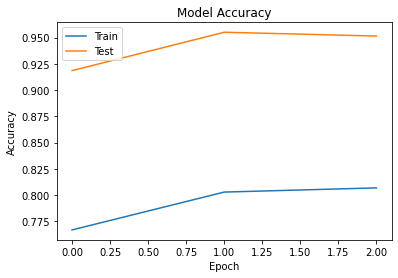

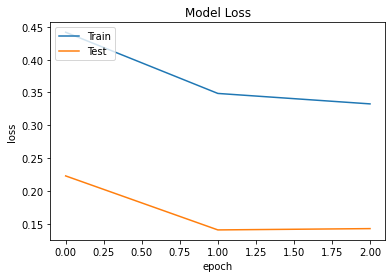

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
os.chdir('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models')
model.save('EfficientNet-Lite4.h5')

# Conversion to TFlite Model

In [ ]:
data_aug = Sequential([
  Resizing(img_height, img_width, interpolation= 'bilinear'),
  Rescaling(1/255)
], name = 'data_augmentation')

In [ ]:
full_model = Sequential()
full_model.add(data_aug)
full_model.add(model)

In [ ]:
full_model.compile(loss = 'categorical_crossentropy', optimizer = Adam())

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(full_model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmpsbure1hs/assets


INFO:tensorflow:Assets written to: /tmp/tmpsbure1hs/assets


In [ ]:
with open('COVID19-Model.tflite', 'wb') as f:
  f.write(tflite_model)

# Plotting the confusion matrix

In [ ]:
model = load_model('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models/Xception-v2.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              13118936  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 13,632,987
Trainable params: 514,051
Non-trainable params: 13,118,936
_________________________________________________________________


In [ ]:
predictions = model.predict(test_gen)

In [ ]:
print(predictions)

[[1.8091941e-01 8.0526924e-01 1.3811385e-02]
 [2.3193788e-02 9.7662354e-01 1.8271182e-04]
 [4.6134543e-02 9.5301223e-01 8.5315265e-04]
 ...
 [5.2049370e-03 9.9182206e-01 2.9729856e-03]
 [2.0031627e-04 6.5147982e-04 9.9914825e-01]
 [2.9847246e-01 6.9905907e-01 2.4685415e-03]]


In [ ]:
rounded_predictions = np.argmax(predictions, axis =1)

In [ ]:
print(list(rounded_predictions))

In [ ]:
labels = test_gen.classes


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [ ]:
class_names = ['covid','non-covid', 'non-informative']

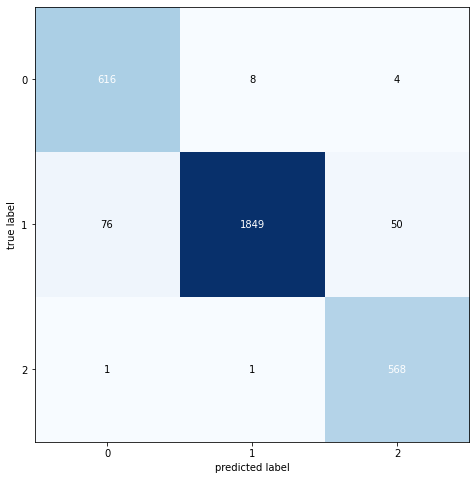

In [ ]:
cs = confusion_matrix(labels, rounded_predictions)
cm = plot_confusion_matrix(conf_mat = cs, figsize =(8,8))